In [1009]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy import stats

sns.set_context("paper", font_scale=1.7)
sns.set_style("ticks", {"axes.grid": True, "grid.color": "0.95", "grid.linestyle": "-"})

# Import Data

In [1010]:
data_df = pd.read_csv('../data/clean/faang_5min_prices.zip')
data_df.head()

,ticker,date,datetime,log_price,price,return
0,AAPL,2019-09-20,2019-09-20 09:35:00,5.403398,222.160,NaN
1,AAPL,2019-09-20,2019-09-20 09:40:00,5.403713,222.230,0.000315
2,AAPL,2019-09-20,2019-09-20 09:45:00,5.402587,221.980,-0.001126
3,AAPL,2019-09-20,2019-09-20 09:50:00,5.401235,221.680,-0.001352
4,AAPL,2019-09-20,2019-09-20 09:55:00,5.401799,221.805,0.000564


# Clean Data

In [1011]:
# Clean up date column
data_df['datetime'] = pd.to_datetime(data_df['datetime'])
data_df['date'] = data_df['datetime'].dt.date
data_df = data_df.sort_values(by = ['ticker', 'date', 'datetime'])

# Add high power returns to speed up RV computation
data_df['return_power_2'] = np.power(data_df['return'], 2)
data_df['return_power_4'] = np.power(data_df['return'], 4)

In [1012]:
# Daily RV
data_daily_df = (
    data_df.groupby(["ticker", "date"])[["return_power_2", "return_power_4"]].sum().reset_index()
)
data_daily_df["RV"] = data_daily_df["return_power_2"]
data_daily_df["se"] = np.sqrt((2 / 3) * data_daily_df["return_power_4"])
data_daily_df.head()

,ticker,date,return_power_2,return_power_4,RV,se
0,AAPL,2019-09-20,0.000197,4.359462e-09,0.000197,0.000054
1,AAPL,2019-09-23,0.000083,7.449121e-10,0.000083,0.000022
2,AAPL,2019-09-24,0.000233,2.427196e-09,0.000233,0.000040
3,AAPL,2019-09-25,0.000075,3.781130e-10,0.000075,0.000016
4,AAPL,2019-09-26,0.000061,1.995445e-10,0.000061,0.000012


In [1013]:
len(data_daily_df['date'].unique())

252

In [1014]:
# 30 min RV
data_30min_df = (
    data_df.groupby(["ticker", "date", pd.Grouper(key="datetime", freq="30min", label = 'right')])[
        ["return_power_2", "return_power_4"]
    ]
    .sum()
    .reset_index()
)
data_30min_df["RV"] = data_30min_df["return_power_2"]
data_30min_df["se"] = np.sqrt((2 / 3) * data_30min_df["return_power_4"])
data_30min_df['datetime'] = pd.to_datetime(data_30min_df['datetime'])
data_30min_df['date'] = pd.to_datetime(data_30min_df['date']) 
data_30min_df.head()

,ticker,date,datetime,return_power_2,return_power_4,RV,se
0,AAPL,2019-09-20,2019-09-20 10:00:00,0.000004,5.061086e-12,0.000004,1.836861e-06
1,AAPL,2019-09-20,2019-09-20 10:30:00,0.000004,7.936706e-12,0.000004,2.300247e-06
2,AAPL,2019-09-20,2019-09-20 11:00:00,0.000005,1.034267e-11,0.000005,2.625855e-06
3,AAPL,2019-09-20,2019-09-20 11:30:00,0.000002,1.424013e-12,0.000002,9.743418e-07
4,AAPL,2019-09-20,2019-09-20 12:00:00,0.000007,3.182828e-11,0.000007,4.606392e-06


In [1015]:
# 1 hr RV
data_60min_df = (
    data_df.groupby(["ticker", "date", pd.Grouper(key="datetime", freq="60min", label = 'right')])[
        ["return_power_2", "return_power_4"]
    ]
    .sum()
    .reset_index()
)
data_60min_df["RV"] = data_60min_df["return_power_2"]
data_60min_df["se"] = np.sqrt((2 / 3) * data_60min_df["return_power_4"])
data_60min_df['datetime'] = pd.to_datetime(data_60min_df['datetime'])
data_60min_df['date'] = pd.to_datetime(data_60min_df['date']) 
data_60min_df.head()

,ticker,date,datetime,return_power_2,return_power_4,RV,se
0,AAPL,2019-09-20,2019-09-20 10:00:00,0.000004,5.061086e-12,0.000004,0.000002
1,AAPL,2019-09-20,2019-09-20 11:00:00,0.000009,1.827938e-11,0.000009,0.000003
2,AAPL,2019-09-20,2019-09-20 12:00:00,0.000009,3.325229e-11,0.000009,0.000005
3,AAPL,2019-09-20,2019-09-20 13:00:00,0.000010,1.814568e-11,0.000010,0.000003
4,AAPL,2019-09-20,2019-09-20 14:00:00,0.000086,3.394678e-09,0.000086,0.000048


In [1016]:
## 20 day RV
# Daily sorted by ticker and date
temp_df = data_daily_df.sort_values(by=["ticker", "date"]).copy()

# For each ticker, count the observation by order of appearance (will be in time order)
temp_df["ticker_idx"] = (
    data_daily_df.sort_values(by=["ticker", "date"])
    .groupby("ticker")["date"]
    .rolling(9999)
    .count()
    .reset_index()["date"]
)

# Mod the time index minus 1 by 20 to get indexed groups of 20 observations
temp_df["ticker_idx_20"] = (temp_df["ticker_idx"] - 1) // 20

# Group by ticker and (groups of 20 index) and then aggregate
data_20day_df = (
    temp_df.groupby(["ticker", "ticker_idx_20"])
    .aggregate({"return_power_2": np.sum, "return_power_4": np.sum, "date": "last"})
    .reset_index()
    .drop("ticker_idx_20", axis=1)
)

# Fix cols
data_20day_df["RV"] = data_20day_df["return_power_2"]
data_20day_df["se"] = np.sqrt((2 / 3) * data_20day_df["return_power_4"])
data_20day_df['date'] = pd.to_datetime(data_20day_df['date']) 
data_20day_df.head()

,ticker,return_power_2,return_power_4,date,RV,se
0,AAPL,0.002197,3.254491e-08,2019-10-17,0.002197,0.000147
1,AAPL,0.001373,8.827812e-09,2019-11-14,0.001373,0.000077
2,AAPL,0.001517,3.387465e-08,2019-12-13,0.001517,0.000150
3,AAPL,0.001605,1.448393e-08,2020-01-14,0.001605,0.000098
4,AAPL,0.002406,2.205743e-08,2020-02-12,0.002406,0.000121


In [1017]:
## 5 day RV
# Daily sorted by ticker and date
temp_df = data_daily_df.sort_values(by=["ticker", "date"]).copy()

# For each ticker, count the observation by order of appearance (will be in time order)
temp_df["ticker_idx"] = (
    data_daily_df.sort_values(by=["ticker", "date"])
    .groupby("ticker")["date"]
    .rolling(9999)
    .count()
    .reset_index()["date"]
)

# Mod the time index minus 1 by 20 to get indexed groups of 5 observations
temp_df["ticker_idx_5"] = (temp_df["ticker_idx"] - 1) // 5

# Group by ticker and (groups of 20 index) and then aggregate
data_5day_df = (
    temp_df.groupby(["ticker", "ticker_idx_5"])
    .aggregate({"return_power_2": np.sum, "return_power_4": np.sum, "date": "last"})
    .reset_index()
    .drop("ticker_idx_5", axis=1)
)

# Fix cols
data_5day_df["RV"] = data_5day_df["return_power_2"]
data_5day_df["se"] = np.sqrt((2 / 3) * data_5day_df["return_power_4"])
data_5day_df['date'] = pd.to_datetime(data_5day_df['date']) 
data_5day_df.head()

,ticker,return_power_2,return_power_4,date,RV,se
0,AAPL,0.000649,8.109227e-09,2019-09-26,0.000649,0.000074
1,AAPL,0.000779,1.931969e-08,2019-10-03,0.000779,0.000113
2,AAPL,0.000492,3.774092e-09,2019-10-10,0.000492,0.000050
3,AAPL,0.000277,1.341905e-09,2019-10-17,0.000277,0.000030
4,AAPL,0.000294,1.303405e-09,2019-10-24,0.000294,0.000029


# Plot Results for One Horizon

## All tickers RV

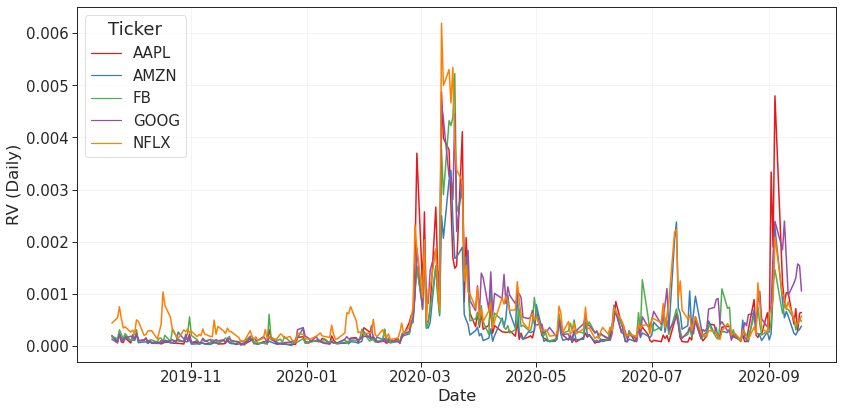

In [1018]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot RV for each series
sns.lineplot(
    x="date", y="RV", hue="ticker", palette=sns.color_palette("Set1", 5), data=data_daily_df, lw=1.5
)

# Fix legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles=handles[1:],
    labels=labels[1:],
    title="Ticker",
    title_fontsize = 18
)

plt.ylabel("RV (Daily)")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig('../exhibits/SA_faang_rv_daily_all.pdf')

## All 5 Seperately RV with CIs

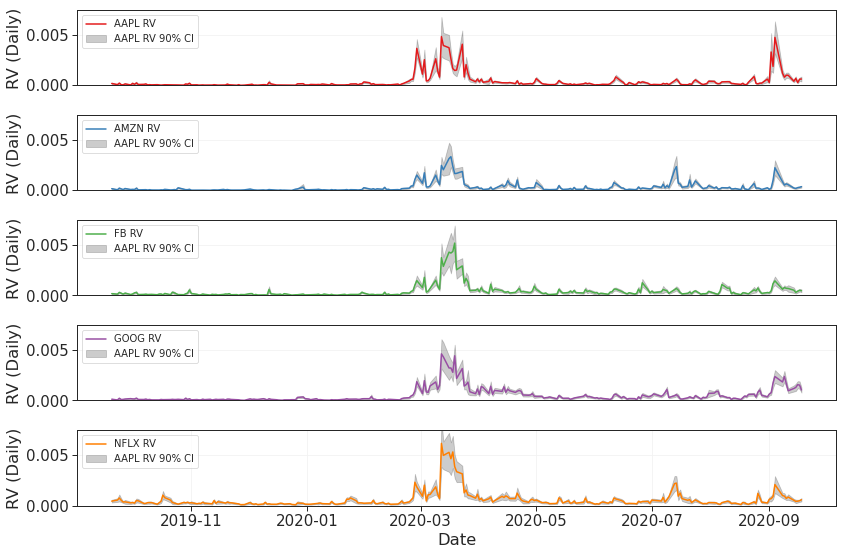

In [1019]:
fig, ax = plt.subplots(figsize=(12, 8), nrows=5, ncols=1, sharex=True, sharey=True)

tickers = data_daily_df["ticker"].unique()

# Plot RV for each series
for i in range(len(tickers)):

    ticker = tickers[i]

    ax = plt.subplot(5, 1, i + 1)
    plt.ylim(0, 0.0075)
    plot_data = data_daily_df.query("ticker == @ticker")

    sns.lineplot(
        x="date",
        y="RV",
        color=sns.color_palette("Set1", 5)[i],
        label=ticker + " RV",
        data=data_daily_df.query("ticker == @ticker"),
        ax=ax,
        **{"lw": 1.5},
    )

    # 90% CI
    plt.fill_between(
        plot_data["date"],
        plot_data["RV"] + plot_data["se"] * stats.norm.ppf(0.05),
        plot_data["RV"] + plot_data["se"] * stats.norm.ppf(0.95),
        color="k",
        alpha=0.2,
        label="AAPL RV 90% CI",
    )
    plt.legend(loc="upper left", fontsize=10)
    plt.ylabel("RV (Daily)")

    if i < 4:
        ax.axes.get_xaxis().set_visible(False)

plt.xlabel("Date")

plt.tight_layout()
plt.savefig('../exhibits/SA_faang_rv_daily_subplots.pdf')

## Just one ticker - RV + CI

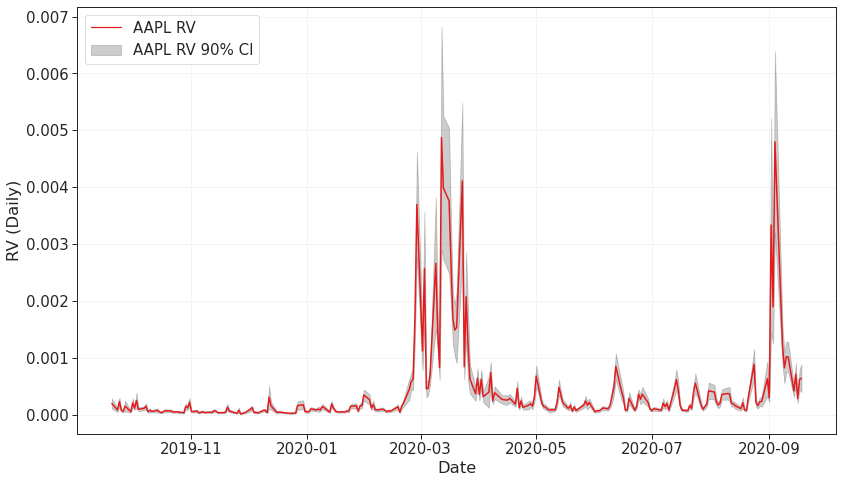

In [1020]:
fig, ax = plt.subplots(figsize=(12, 7))

# Plot RV for one ticker
plot_data = data_daily_df.query('ticker == "AAPL"')

# RV Line
sns.lineplot(
    x="date",
    y="RV",
    hue="ticker",
    label="AAPL RV",
    palette=sns.color_palette("Set1", 5)[:1],
    data=plot_data,
    lw=1.5,
)

# 90% CI
plt.fill_between(
    plot_data["date"],
    plot_data["RV"] + plot_data["se"] * stats.norm.ppf(0.05),
    plot_data["RV"] + plot_data["se"] * stats.norm.ppf(0.95),
    color="k",
    alpha=0.2,
    label="AAPL RV 90% CI",
)

# Fix legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    loc="upper left",
    handles=handles[2:],
    labels=["AAPL RV", "AAPL RV 90% CI"],
    title="",
    title_fontsize=18,
)

plt.ylabel("RV (Daily)")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig('../exhibits/SA_aapl_rv_daily.pdf')

#### Same but Weekly

Text(0.5, 0, 'Date')

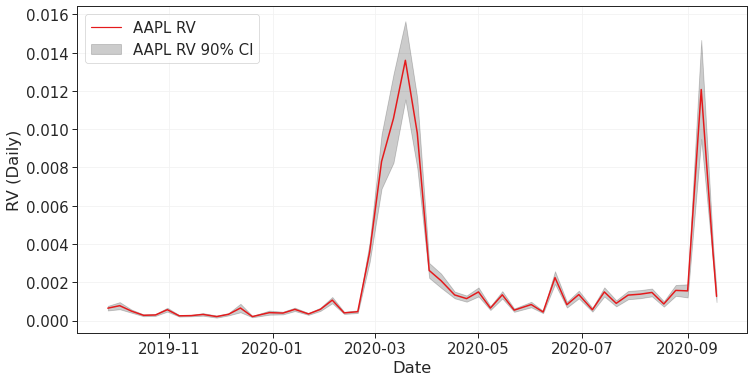

In [1021]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot RV for one ticker
plot_data = data_5day_df.query('ticker == "AAPL"')

# RV Line
sns.lineplot(
    x="date",
    y="RV",
    hue="ticker",
    label="AAPL RV",
    palette=sns.color_palette("Set1", 5)[:1],
    data=plot_data,
    lw=1.5,
)

# 90% CI
plt.fill_between(
    plot_data["date"],
    plot_data["RV"] + plot_data["se"] * stats.norm.ppf(0.05),
    plot_data["RV"] + plot_data["se"] * stats.norm.ppf(0.95),
    color="k",
    alpha=0.2,
    label="AAPL RV 90% CI",
)

# Fix legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    loc="upper left",
    handles=handles[2:],
    labels=["AAPL RV", "AAPL RV 90% CI"],
    title="",
    title_fontsize=18,
)

plt.ylabel("RV (Daily)")
plt.xlabel("Date")

## Just one ticker - RV + CI , July onward

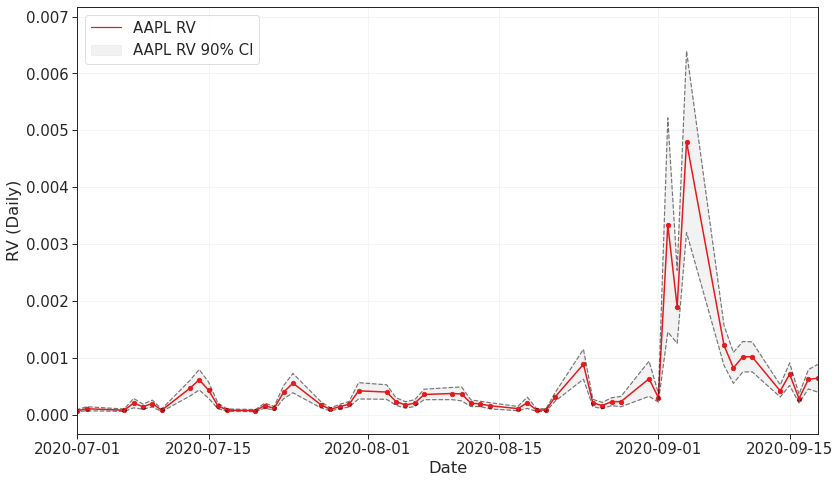

In [1022]:
fig, ax = plt.subplots(figsize=(12, 7))

# Plot RV for one ticker
plot_data = data_daily_df.query('ticker == "AAPL"')

# RV Line
sns.lineplot(
    x="date",
    y="RV",
    hue="ticker",
    label="AAPL RV",
    palette=sns.color_palette("Set1", 5)[:1],
    data=plot_data,
    lw=1.5,
)


# 90% CI
plt.fill_between(
    plot_data["date"],
    plot_data["RV"] + plot_data["se"] * stats.norm.ppf(0.05),
    plot_data["RV"] + plot_data["se"] * stats.norm.ppf(0.95),
    color="k",
    alpha=0.05,
    label="AAPL RV 90% CI",
)


# RV dots
plt.scatter(x=plot_data["date"], y=plot_data["RV"], color=sns.color_palette("Set1", 5)[0], s=20)

# CI dashed lines
plt.plot(
    plot_data["date"],
    plot_data["RV"] + plot_data["se"] * stats.norm.ppf(0.05),
    color="k",
    alpha=0.5,
    ls="dashed",
)
plt.plot(
    plot_data["date"],
    plot_data["RV"] + plot_data["se"] * stats.norm.ppf(0.95),
    color="k",
    alpha=0.5,
    ls="dashed",
)

# Fix legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    loc="upper left",
    handles=handles[2:],
    labels=["AAPL RV", "AAPL RV 90% CI"],
    title="",
    title_fontsize=18,
)

plt.ylabel("RV (Daily)")
plt.xlabel("Date")

# Zoom
plt.xlim(pd.to_datetime("2020-07-01"), plot_data["date"].max())

plt.ylabel("RV (Daily)")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig('../exhibits/SA_aapl_rv_daily_zoom.pdf')

# Plot Results for Multiple Horizon

## For all 5

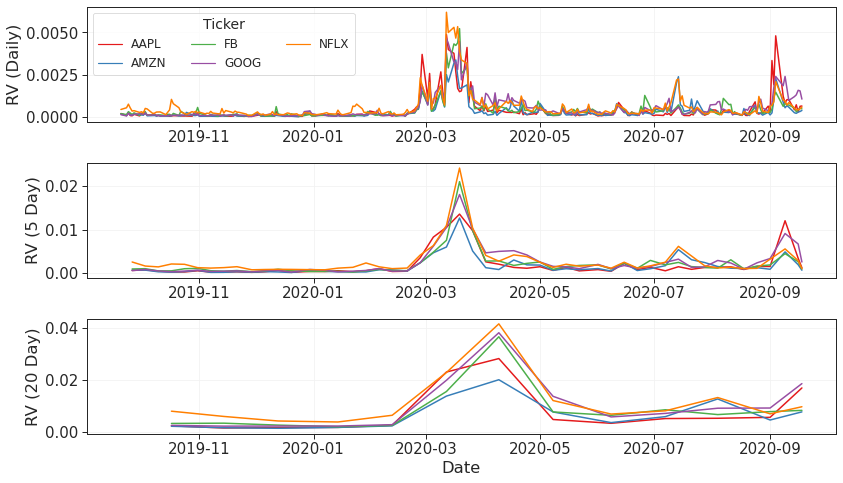

In [1023]:
fig, ax = plt.subplots(figsize=(12, 7), nrows = 3, sharex = True)


def plot_stuff(plot_data):
    
    # Plot RV for each series
    sns.lineplot(
        x="date", y="RV", hue="ticker", palette=sns.color_palette("Set1", 5), data=plot_data, lw=1.5
    )

    # Fix legend
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(
        handles=handles[1:],
        labels=labels[1:],
        title="Ticker",
        title_fontsize = 14,
        fontsize = 12,
        ncol = 3
    )

ax = plt.subplot(3,1,1)
plot_stuff(data_daily_df)
plt.ylabel("RV (Daily)")
plt.xlabel('')
xlims = plt.xlim()

ax = plt.subplot(3,1,2)
plot_stuff(data_5day_df)
plt.ylabel("RV (5 Day)")
plt.xlabel('')
ax.get_legend().remove()
plt.xlim(xlims)

ax = plt.subplot(3,1,3)
plot_stuff(data_20day_df)
plt.ylabel("RV (20 Day)")
plt.xlabel("Date")
ax.get_legend().remove()
plt.xlim(xlims)

plt.tight_layout()
plt.savefig('../exhibits/SA_faang_3T.pdf')

## Singles

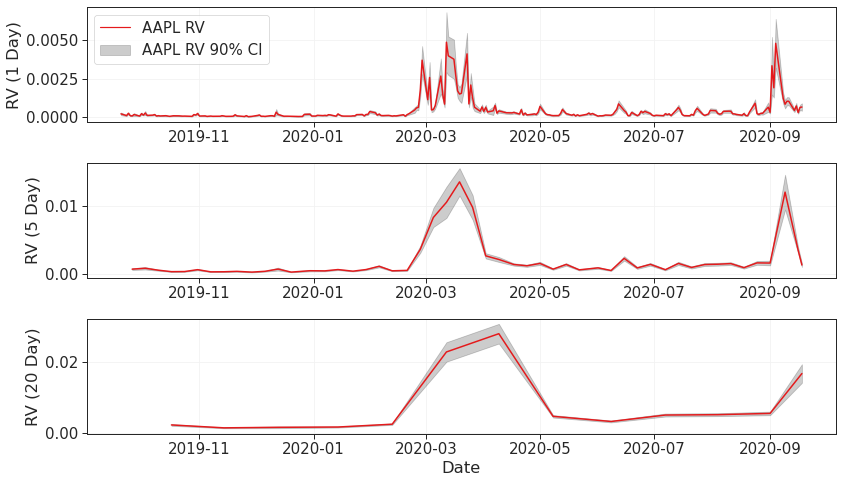

In [1053]:
ticker = 'AAPL'

fig, ax = plt.subplots(figsize=(12, 7), nrows = 3)

def plot_stuff(plot_data):
    # RV Line
    sns.lineplot(
        x="date",
        y="RV",
        hue="ticker",
        label="AAPL RV",
        palette=sns.color_palette("Set1", 5)[:1],
        data=plot_data,
        lw=1.5,
    )
    
    # 90% CI
    plt.fill_between(
        plot_data["date"],
        plot_data["RV"] + plot_data["se"] * stats.norm.ppf(0.05),
        plot_data["RV"] + plot_data["se"] * stats.norm.ppf(0.95),
        color="k",
        alpha=0.2,
        label="AAPL RV 90% CI",
    )

    # Fix legend
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(
        loc="upper left",
        handles=handles[2:],
        labels=["AAPL RV", "AAPL RV 90% CI"],
        title="",
        title_fontsize=18,
    )

## For daily
ax = plt.subplot(3,1,1)
plot_data = data_daily_df.query('ticker == @ticker')
plot_stuff(plot_data)
plt.ylabel("RV (1 Day)")
plt.xlabel('')
xlims = plt.xlim()

## For week
ax = plt.subplot(3,1,2)
plot_data = data_5day_df.query('ticker == @ticker')
plot_stuff(plot_data)
plt.ylabel("RV (5 Day)")
plt.xlabel('')
ax.get_legend().remove()
plt.xlim(xlims)

## For 20day
ax = plt.subplot(3,1,3)
plot_data = data_20day_df.query('ticker == @ticker')
plot_stuff(plot_data)
plt.ylabel("RV (20 Day)")
plt.xlabel("Date")
ax.get_legend().remove()
plt.xlim(xlims)

plt.tight_layout()
plt.savefig('../exhibits/SA_aapl_rv_3T_subplots.pdf')

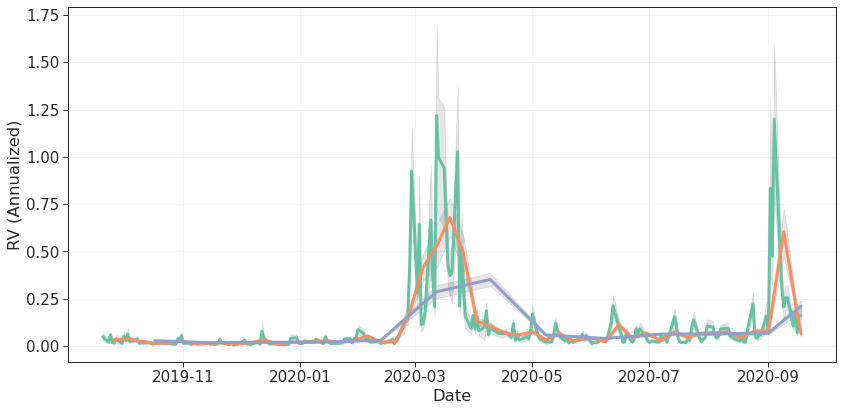

In [1025]:
ticker = 'AAPL'

fig, ax = plt.subplots(figsize=(12, 6), nrows = 1)

def plot_stuff(plot_data, color):
    # RV Line
    sns.lineplot(
        x="date",
        y="RV",
        label="AAPL RV",
        color=color,
        data=plot_data,
        lw=3,
    )
    
    # 90% CI
    plt.fill_between(
        plot_data["date"],
        plot_data["RV"] + plot_data["se"] * stats.norm.ppf(0.05),
        plot_data["RV"] + plot_data["se"] * stats.norm.ppf(0.95),
        color="k",
        alpha=0.1,
        label="AAPL RV 90% CI",
    )

    # Fix legend
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(
        loc="upper left",
        handles=handles[2:],
        labels=["AAPL RV", "AAPL RV 90% CI"],
        title="",
        title_fontsize=18,
    )

## For daily
plot_data = data_daily_df.query('ticker == @ticker').copy()
plot_data['RV'] = plot_data['RV']*250
plot_data['se'] = plot_data['se']*250
plot_stuff(plot_data, color = sns.color_palette("Set2", 3)[0])
plt.ylabel("RV (1 Day)")
plt.xlabel('')

## For week
plot_data = data_5day_df.query('ticker == @ticker').copy()
plot_data['RV'] = plot_data['RV']*250/5
plot_data['se'] = plot_data['se']*250/5
plot_stuff(plot_data, sns.color_palette("Set2", 3)[1])
plt.ylabel("RV (5 Day)")
plt.xlabel('')

## For 20day
plot_data = data_20day_df.query('ticker == @ticker').copy()
plot_data['RV'] = plot_data['RV']*250/20
plot_data['se'] = plot_data['se']*250/20
plot_stuff(plot_data, sns.color_palette("Set2", 3)[2])

ax.get_legend().remove()
plt.ylabel("RV (Annualized)")
plt.xlabel("Date")
plt.tight_layout()

## Zoom previous

In [1055]:
data_daily_df.query('ticker == "AAPL"').tail()

,ticker,date,return_power_2,return_power_4,RV,se
247,AAPL,2020-09-14,0.000418,6.303165e-09,0.000418,0.000065
248,AAPL,2020-09-15,0.000713,2.186635e-08,0.000713,0.000121
249,AAPL,2020-09-16,0.000283,3.270818e-09,0.000283,0.000047
250,AAPL,2020-09-17,0.000623,1.610911e-08,0.000623,0.000104
251,AAPL,2020-09-18,0.000641,3.290384e-08,0.000641,0.000148


In [1056]:
def plot_stuff(plot_data):
    # RV Line
    sns.lineplot(
        x="date",
        y="RV",
        hue="ticker",
        label="AAPL RV",
        palette=sns.color_palette("Set1", 5)[:1],
        data=plot_data,
        lw=1.5,
    )


    # 90% CI
    plt.fill_between(
        plot_data["date"],
        plot_data["RV"] + plot_data["se"] * stats.norm.ppf(0.05),
        plot_data["RV"] + plot_data["se"] * stats.norm.ppf(0.95),
        color="k",
        alpha=0.05,
        label="AAPL RV 90% CI",
    )

    # RV dots
    plt.scatter(x=plot_data["date"], y=plot_data["RV"], color=sns.color_palette("Set1", 5)[0], s=20)

    # CI dashed lines
    plt.plot(
        plot_data["date"],
        plot_data["RV"] + plot_data["se"] * stats.norm.ppf(0.05),
        color="k",
        alpha=0.5,
        ls="dashed",
    )
    plt.plot(
        plot_data["date"],
        plot_data["RV"] + plot_data["se"] * stats.norm.ppf(0.95),
        color="k",
        alpha=0.5,
        ls="dashed",
    )

    # Fix legend
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(
        loc="upper left",
        handles=handles[2:],
        labels=["AAPL RV", "AAPL RV 90% CI"],
        title="",
        title_fontsize=18,
    )

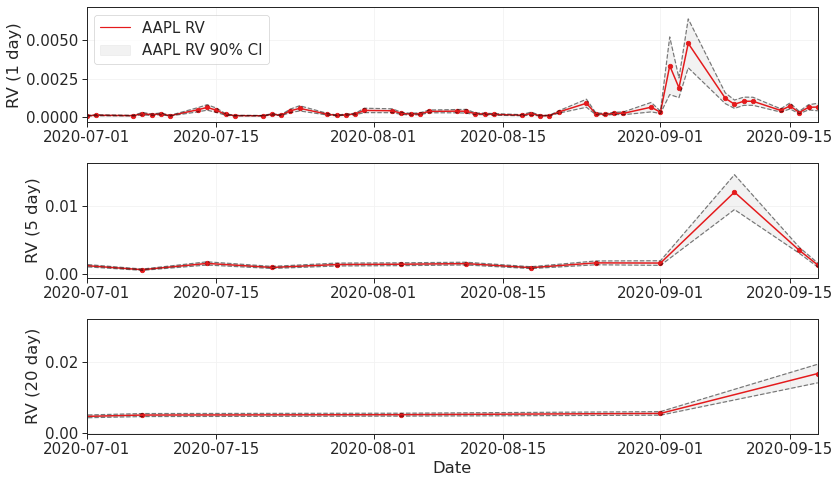

In [1057]:
ticker = 'AAPL'

fig, ax = plt.subplots(figsize=(12, 7), nrows = 2)

## For daily
ax = plt.subplot(3,1,1)
plot_data = data_daily_df.query('ticker == @ticker')
plot_stuff(plot_data)
plt.xlim(pd.to_datetime("2020-07-01"), plot_data["date"].max())
plt.xlabel('')
plt.ylabel("RV (1 day)")

## For week
ax = plt.subplot(3,1,2)
plot_data = data_5day_df.query('ticker == @ticker')
plot_stuff(plot_data)
plt.xlim(pd.to_datetime("2020-07-01"), plot_data["date"].max())
ax.get_legend().remove()
plt.xlabel('')
plt.ylabel("RV (5 day)")

## For 20 day
ax = plt.subplot(3,1,3)
plot_data = data_20day_df.query('ticker == @ticker')
plot_stuff(plot_data)
plt.xlim(pd.to_datetime("2020-07-01"), plot_data["date"].max())
ax.get_legend().remove()

plt.ylabel("RV (20 day)")
plt.xlabel("Date")

plt.tight_layout()
plt.savefig('../exhibits/SA_aapl_rv_3T_subplots_zoom.pdf')

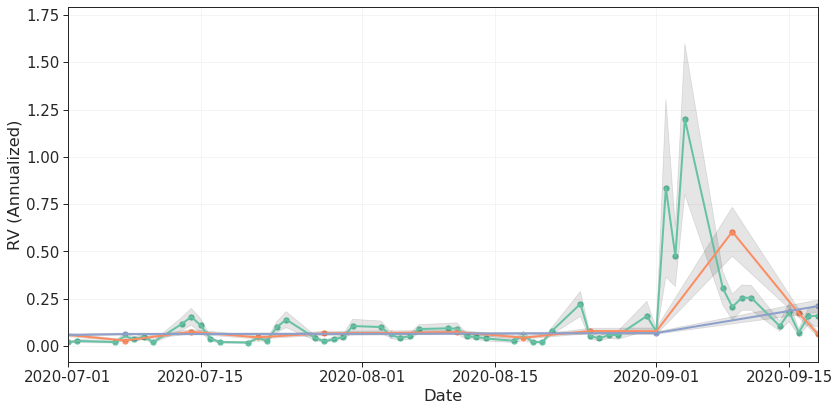

In [1029]:
ticker = 'AAPL'

fig, ax = plt.subplots(figsize=(12, 6), nrows = 1)

def plot_stuff(plot_data, color):
    # RV Line
    sns.lineplot(
        x="date",
        y="RV",
        label="AAPL RV",
        color=color,
        data=plot_data,
        lw=2,
    )
    sns.scatterplot(
        x="date",
        y="RV",
        label="AAPL RV",
        color=color,
        data=plot_data,
        s=50
    )
    
    # 90% CI
    plt.fill_between(
        plot_data["date"],
        plot_data["RV"] + plot_data["se"] * stats.norm.ppf(0.05),
        plot_data["RV"] + plot_data["se"] * stats.norm.ppf(0.95),
        color="k",
        alpha=0.1,
        label="AAPL RV 90% CI",
    )

    # Fix legend
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(
        loc="upper left",
        handles=handles[2:],
        labels=["AAPL RV", "AAPL RV 90% CI"],
        title="",
        title_fontsize=18,
    )

## For daily
plot_data = data_daily_df.query('ticker == @ticker').copy()
plot_data['RV'] = plot_data['RV']*250
plot_data['se'] = plot_data['se']*250
plot_stuff(plot_data, color = sns.color_palette("Set2", 3)[0])
plt.ylabel("RV (1 Day)")
plt.xlabel('')

## For week
plot_data = data_5day_df.query('ticker == @ticker').copy()
plot_data['RV'] = plot_data['RV']*250/5
plot_data['se'] = plot_data['se']*250/5
plot_stuff(plot_data, sns.color_palette("Set2", 3)[1])
plt.ylabel("RV (5 Day)")
plt.xlabel('')

## For 20day
plot_data = data_20day_df.query('ticker == @ticker').copy()
plot_data['RV'] = plot_data['RV']*250/20
plot_data['se'] = plot_data['se']*250/20
plot_stuff(plot_data, sns.color_palette("Set2", 3)[2])

ax.get_legend().remove()
plt.xlim(pd.to_datetime("2020-07-01"), plot_data["date"].max())
plt.ylabel("RV (Annualized)")
plt.xlabel("Date")
plt.tight_layout()

# Test RV Change

In [1030]:
data_091620_30min_df = data_30min_df.loc[data_30min_df['date'] == pd.to_datetime('2020-09-16'), :]

In [1031]:
data_091620_30min_df.head()

,ticker,date,datetime,return_power_2,return_power_4,RV,se
3486,AAPL,2020-09-16,2020-09-16 10:00:00,0.000042,9.158981e-10,0.000042,0.000025
3487,AAPL,2020-09-16,2020-09-16 10:30:00,0.000011,5.021933e-11,0.000011,0.000006
3488,AAPL,2020-09-16,2020-09-16 11:00:00,0.000029,2.673571e-10,0.000029,0.000013
3489,AAPL,2020-09-16,2020-09-16 11:30:00,0.000017,1.012259e-10,0.000017,0.000008
3490,AAPL,2020-09-16,2020-09-16 12:00:00,0.000005,9.609335e-12,0.000005,0.000003


## Plots

### Sep 16 Statement

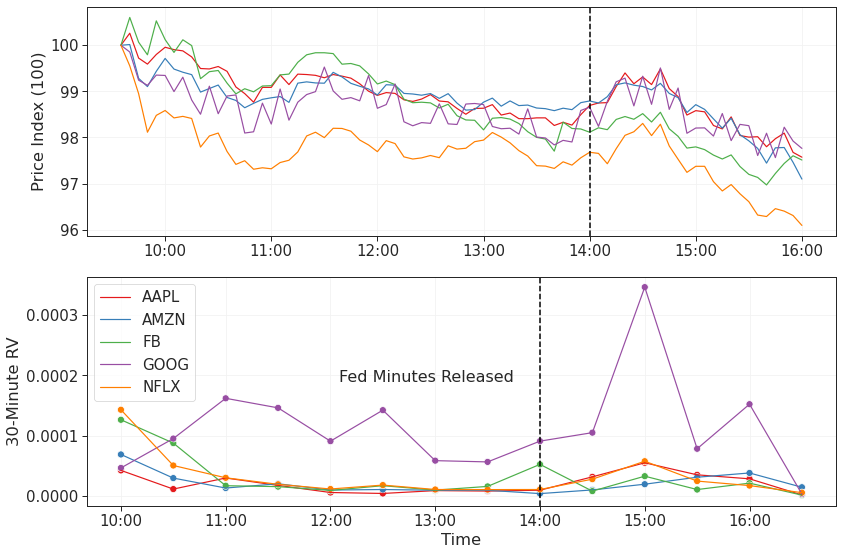

In [1058]:
fig, ax = plt.subplots(figsize=(12, 8), nrows=2)

# Price
ax = plt.subplot(2, 1, 1)

plot_data = data_df.loc[data_df["date"] == pd.to_datetime("2020-09-16"), :].copy()
plot_data["price_idx"] = (
    100 * plot_data["price"] / plot_data.groupby("ticker")["price"].transform("first")
)

sns.lineplot(
    x="datetime", y="price_idx", hue="ticker", palette=sns.color_palette("Set1", 5), data=plot_data,
)
# Vline at 2PM
ax.axvline(
    x=pd.to_datetime(f"{'2020-09-16'} 14:00:00"), ymin=0, ymax=1, lw=1.5, ls="--", color="k",
)
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M"))
plt.xlabel("")
plt.ylabel("Price Index (100)")
ax.get_legend().remove()

# RV
ax = plt.subplot(2, 1, 2)
sns.lineplot(
    x="datetime",
    y="RV",
    hue="ticker",
    palette=sns.color_palette("Set1", 5),
    data=data_091620_30min_df,
    ax=ax,
)
sns.scatterplot(
    x="datetime",
    y="RV",
    hue="ticker",
    palette=sns.color_palette("Set1", 5),
    data=data_091620_30min_df,
    ax=ax,
    s=50,
)

# Vline at 2PM
ax.axvline(
    x=pd.to_datetime(f"{'2020-09-16'} 14:00:00"), ymin=0, ymax=1, lw=1.5, ls="--", color="k",
)
# Text
plt.text(
    pd.to_datetime(f"{'2020-09-16'} 13:45:00"),
    0.0002,
    "Fed Minutes Released",
    size=16,
    ha="right",
    va="center_baseline",
)
plt

# Fix legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    loc="upper left", handles=handles[1:6], labels=labels[1:6], title="", title_fontsize=18,
)

plt.xlabel("Time")
plt.ylabel("30-Minute RV")
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M"))
plt.tight_layout()
plt.savefig('../exhibits/SA_sep16_rv.pdf')

### Aug 19 FOMC Minutes

In [1033]:
data_30min_df.loc[pd.to_datetime(data_30min_df['date']) == '2020-08-19', :]

,ticker,date,datetime,return_power_2,return_power_4,RV,se
3220,AAPL,2020-08-19,2020-08-19 10:00:00,9.834152e-06,4.732267e-11,9.834152e-06,5.616801e-06
3221,AAPL,2020-08-19,2020-08-19 10:30:00,9.266146e-06,2.175333e-11,9.266146e-06,3.808178e-06
3222,AAPL,2020-08-19,2020-08-19 11:00:00,6.285820e-06,1.031533e-11,6.285820e-06,2.622382e-06
3223,AAPL,2020-08-19,2020-08-19 11:30:00,1.366957e-05,1.098469e-10,1.366957e-05,8.557528e-06
3224,AAPL,2020-08-19,2020-08-19 12:00:00,4.022123e-06,4.133024e-12,4.022123e-06,1.659924e-06
...,...,...,...,...,...,...,...
17337,NFLX,2020-08-19,2020-08-19 14:30:00,1.768317e-05,1.056368e-10,1.768317e-05,8.391931e-06
17338,NFLX,2020-08-19,2020-08-19 15:00:00,9.134215e-06,2.345050e-11,9.134215e-06,3.953943e-06
17339,NFLX,2020-08-19,2020-08-19 15:30:00,2.405570e-06,1.830536e-12,2.405570e-06,1.104698e-06
17340,NFLX,2020-08-19,2020-08-19 16:00:00,1.208206e-05,7.136873e-11,1.208206e-05,6.897765e-06


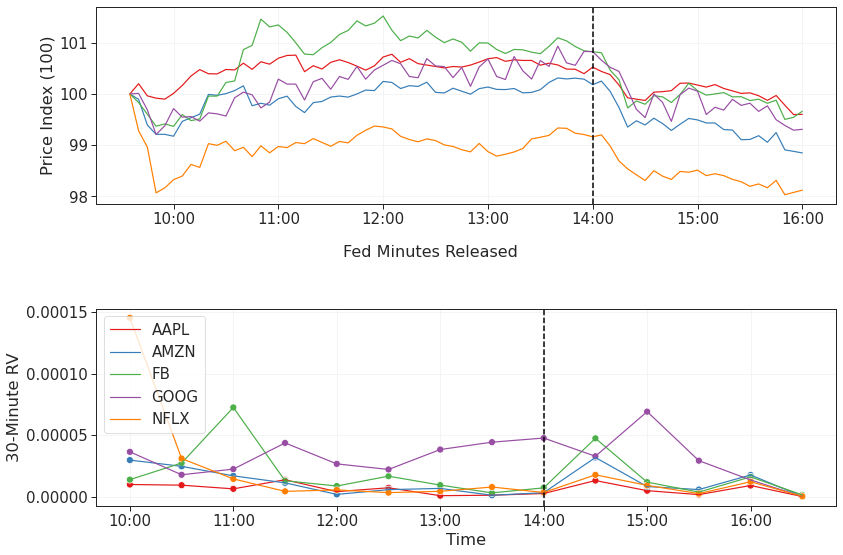

In [1059]:
fig, ax = plt.subplots(figsize=(12, 8), nrows=2)

# Price
ax = plt.subplot(2, 1, 1)

plot_data = data_df.loc[data_df["date"] == pd.to_datetime("2020-08-19"), :].copy()
plot_data["price_idx"] = (
    100 * plot_data["price"] / plot_data.groupby("ticker")["price"].transform("first")
)

sns.lineplot(
    x="datetime", y="price_idx", hue="ticker", palette=sns.color_palette("Set1", 5), data=plot_data,
)
# Vline at 2PM
ax.axvline(
    x=pd.to_datetime(f"{'2020-08-19'} 14:00:00"), ymin=0, ymax=1, lw=1.5, ls="--", color="k",
)
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M"))
plt.xlabel("")
plt.ylabel("Price Index (100)")
ax.get_legend().remove()

# RV
ax = plt.subplot(2, 1, 2)
sns.lineplot(
    x="datetime",
    y="RV",
    hue="ticker",
    palette=sns.color_palette("Set1", 5),
    data=data_30min_df.loc[data_30min_df['date'] == '2020-08-19', :],
    ax=ax,
)
sns.scatterplot(
    x="datetime",
    y="RV",
    hue="ticker",
    palette=sns.color_palette("Set1", 5),
    data=data_30min_df.loc[data_30min_df['date'] == '2020-08-19', :],
    ax=ax,
    s=50,
)

# Vline at 2PM
ax.axvline(
    x=pd.to_datetime(f"{'2020-08-19'} 14:00:00"), ymin=0, ymax=1, lw=1.5, ls="--", color="k",
)
# Text
plt.text(
    pd.to_datetime(f"{'2020-08-19'} 13:45:00"),
    0.0002,
    "Fed Minutes Released",
    size=16,
    ha="right",
    va="center_baseline",
)
plt

# Fix legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    loc="upper left", handles=handles[1:6], labels=labels[1:6], title="", title_fontsize=18,
)

plt.xlabel("Time")
plt.ylabel("30-Minute RV")
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M"))
plt.tight_layout()
plt.savefig('../exhibits/SA_aug19_rv.pdf')

## Results

In [1035]:
def sig_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

In [1036]:
def test_RV_change(data_df, time_before, time_after, ticker):

    obs_before = (
        data_df.loc[(data_df["datetime"] == time_before), :]
        .query("ticker == @ticker")
        .iloc[0]
    )
    obs_after = (
        data_df.loc[(data_df["datetime"] == time_after), :]
        .query("ticker == @ticker")
        .iloc[0]
    )

    rv_before = obs_before["RV"]
    rv_after = obs_after["RV"]
    rv_difference = rv_after - rv_before
    se_difference = np.sqrt(obs_before["se"] ** 2 + obs_before["se"] ** 2)
    t_stat = rv_difference / se_difference
    p_value = 2 * stats.norm.cdf(-np.abs(t_stat))

    return dict(
        zip(
            ["rv_before", "rv_after", "rv_difference", "se_difference", "t_stat", "p"],
            [rv_before, rv_after, rv_difference, se_difference, t_stat, p_value],
        )
    )

### Sept 16 Statement

In [1037]:
# Do t-test for Sept 16
data_ttest_df = data_30min_df.groupby('ticker').apply(lambda x: test_RV_change(x, "2020-09-16 14:00:00",
"2020-09-16 14:30:00", x['ticker'][0])).apply(pd.Series).reset_index()

In [1038]:
# Fix RV units to annualize
data_ttest_df[["rv_before", "rv_after", "rv_difference"]] = data_ttest_df[
    ["rv_before", "rv_after", "rv_difference"]
] * 250 * (390/30)

In [1039]:
print(data_ttest_df.drop(['se_difference'], axis = 1).set_index('ticker').to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  rv\_before &  rv\_after &  rv\_difference &    t\_stat &         p \\
ticker &            &           &                &           &           \\
\midrule
AAPL   &   0.029353 &  0.101636 &       0.072283 &  3.194422 &  0.001401 \\
AMZN   &   0.011052 &  0.030848 &       0.019796 &  2.162553 &  0.030576 \\
FB     &   0.169036 &  0.024421 &      -0.144615 & -0.920583 &  0.357268 \\
GOOG   &   0.294730 &  0.340595 &       0.045865 &  0.196952 &  0.843865 \\
NFLX   &   0.033192 &  0.089124 &       0.055931 &  2.590438 &  0.009585 \\
\bottomrule
\end{tabular}



### All Statements

In [1040]:
statement_release_datetimes = [
    "2020-01-29 14:00:00",
    "2020-03-03 10:00:00",
    "2020-04-29 14:00:00",
    "2020-06-10 14:00:00",
    "2020-07-29 14:00:00",
    '2020-09-16 14:00:00'
]

#### 30 Min

In [1041]:
data_ttest_df_list = []

for start_dt in statement_release_datetimes:

    start_dt = pd.to_datetime(start_dt)
    end_dt = start_dt + pd.Timedelta("30min")

    # Do ttest
    data_ttest_df = (
        data_30min_df.groupby("ticker")
        .apply(lambda x: test_RV_change(x, start_dt, end_dt, x["ticker"][0]))
        .apply(pd.Series)
        .reset_index()
    )
    
    # Add date col
    data_ttest_df["date"] = pd.to_datetime(start_dt).date()
    
    # Fix RV units to annualize
    data_ttest_df[["rv_before", "rv_after", "rv_difference"]] = data_ttest_df[
        ["rv_before", "rv_after", "rv_difference"]
    ] * 250 * (390/30)

    data_ttest_df_list.append(data_ttest_df)
    
data_ttest_all_df = pd.concat(data_ttest_df_list).reset_index(drop = True)
data_ttest_all_df.sample(5)

,ticker,rv_before,rv_after,rv_difference,se_difference,t_stat,p,date
12,FB,0.061395,0.051062,-0.010332,0.000010,-0.303308,0.761655,2020-04-29
29,NFLX,0.033192,0.089124,0.055931,0.000007,2.590438,0.009585,2020-09-16
8,GOOG,0.371529,1.670148,1.298619,0.000103,3.893613,0.000099,2020-03-03
3,GOOG,0.029037,0.040811,0.011775,0.000005,0.663355,0.507103,2020-01-29
9,NFLX,1.080642,1.195052,0.114410,0.000259,0.136014,0.891810,2020-03-03


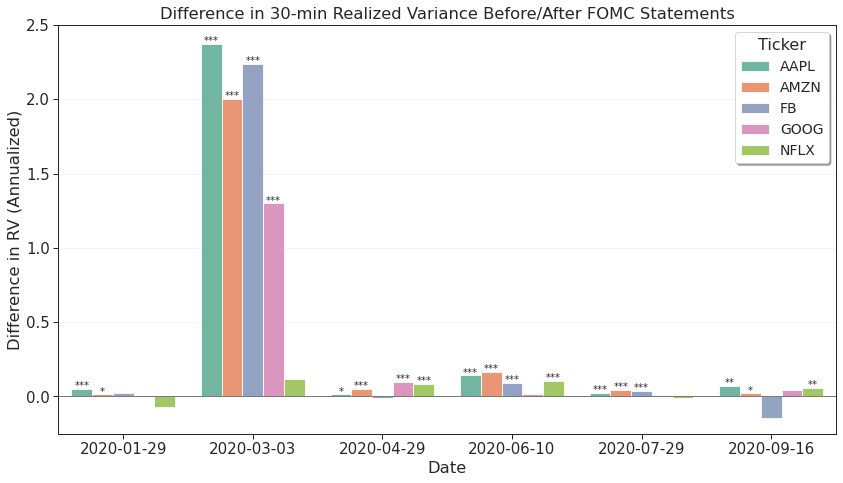

In [1042]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(
    y="rv_difference",
    x="date",
    hue="ticker",
    palette=sns.color_palette("Set2", 5),
    data=data_ttest_all_df,
    ax=ax,
)
plt.axhline(0, -1, 1, color="k", lw=0.5)

# Add significance stars
plt.ylim(-1, 1)
for rectangle in ax.patches:
    x, y = rectangle.get_xy()
    height = rectangle.get_height()
    width = rectangle.get_width()
    x_loc = x + width / 2
    y_loc = height if height > 0 else height - 0.045
    pvalue = data_ttest_all_df["p"].loc[
        (np.abs(data_ttest_all_df["rv_difference"] - height)).idxmin()
    ]
    plt.text(x_loc, y_loc, sig_stars(pvalue), fontsize = 10, ha="center")

# Fix legend
plt.legend(
    loc="upper right",
    title="Ticker",
    title_fontsize=16,
    fontsize=14,
    shadow=True,
)

plt.ylim(-0.25, 2.5)
plt.title('Difference in 30-min Realized Variance Before/After FOMC Statements')
plt.ylabel('Difference in RV (Annualized)')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig('../exhibits/rv_diffs_statements.pdf')

#### 60 Min

In [1043]:
data_ttest_df_list = []

for start_dt in statement_release_datetimes:

    start_dt = pd.to_datetime(start_dt)
    end_dt = start_dt + pd.Timedelta("60min")

    # Do ttest
    data_ttest_df = (
        data_60min_df.groupby("ticker")
        .apply(lambda x: test_RV_change(x, start_dt, end_dt, x["ticker"][0]))
        .apply(pd.Series)
        .reset_index()
    )
    
    # Add date col
    data_ttest_df["date"] = pd.to_datetime(start_dt).date()
    
    # Fix RV units to annualize
    data_ttest_df[["rv_before", "rv_after", "rv_difference"]] = data_ttest_df[
        ["rv_before", "rv_after", "rv_difference"]
    ] * 250 * (390/60)

    data_ttest_df_list.append(data_ttest_df)
    
data_ttest_all_df = pd.concat(data_ttest_df_list).reset_index(drop = True)
data_ttest_all_df.sample(5)

,ticker,rv_before,rv_after,rv_difference,se_difference,t_stat,p,date
3,GOOG,0.025610,0.031242,0.005632,0.000007,0.498566,0.618085,2020-01-29
26,AMZN,0.020091,0.046345,0.026254,0.000006,2.732791,0.006280,2020-09-16
28,GOOG,0.238562,0.733972,0.495410,0.000084,3.610390,0.000306,2020-09-16
9,NFLX,0.540321,0.831765,0.291444,0.000259,0.692952,0.488339,2020-03-03
21,AMZN,0.030580,0.042987,0.012407,0.000010,0.759139,0.447770,2020-07-29


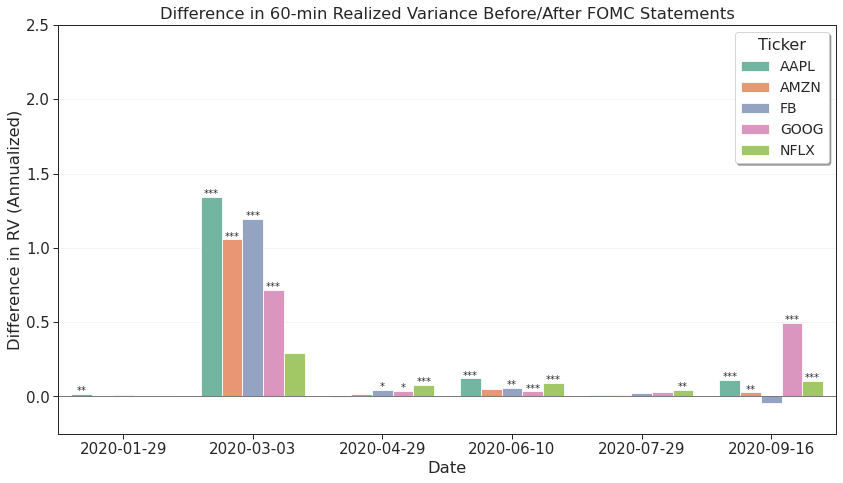

In [1044]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(
    y="rv_difference",
    x="date",
    hue="ticker",
    palette=sns.color_palette("Set2", 5),
    data=data_ttest_all_df,
    ax=ax,
)
plt.axhline(0, -1, 1, color="k", lw=0.5)

# Add significance stars
plt.ylim(-1, 1)
for rectangle in ax.patches:
    x, y = rectangle.get_xy()
    height = rectangle.get_height()
    width = rectangle.get_width()
    x_loc = x + width / 2
    y_loc = height if height > 0 else height - 0.045
    pvalue = data_ttest_all_df["p"].loc[
        (np.abs(data_ttest_all_df["rv_difference"] - height)).idxmin()
    ]
    plt.text(x_loc, y_loc, sig_stars(pvalue), fontsize = 10, ha="center")

# Fix legend
plt.legend(
    loc="upper right",
    title="Ticker",
    title_fontsize=16,
    fontsize=14,
    shadow=True,
)

plt.ylim(-0.25, 2.5)
plt.title('Difference in 60-min Realized Variance Before/After FOMC Statements')
plt.ylabel('Difference in RV (Annualized)')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig('../exhibits/rv_diffs_statements_60min.pdf')

### August 19 Minutes

In [1045]:
# Do t-test 
data_ttest_df = data_30min_df.groupby('ticker').apply(lambda x: test_RV_change(x, "2020-08-19 14:00:00",
"2020-08-19 14:30:00", x['ticker'][0])).apply(pd.Series).reset_index()

In [1046]:
# Fix RV units to annualize
data_ttest_df[["rv_before", "rv_after", "rv_difference"]] = data_ttest_df[
    ["rv_before", "rv_after", "rv_difference"]
] * 250 * (390/30)

In [1047]:
print(data_ttest_df.drop(['se_difference'], axis = 1).set_index('ticker').round(6).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  rv\_before &  rv\_after &  rv\_difference &     t\_stat &         p \\
ticker &            &           &                &            &           \\
\midrule
AAPL   &   0.008097 &  0.042391 &       0.034294 &   6.995757 &  0.000000 \\
AMZN   &   0.010174 &  0.103357 &       0.093183 &  11.469513 &  0.000000 \\
FB     &   0.023061 &  0.154106 &       0.131045 &   9.453751 &  0.000000 \\
GOOG   &   0.154833 &  0.106632 &      -0.048201 &  -0.537640 &  0.590825 \\
NFLX   &   0.010834 &  0.057470 &       0.046637 &   5.407296 &  0.000000 \\
\bottomrule
\end{tabular}



### All FOMC Minutes

In [1048]:
statement_release_datetimes = [
    "2020-01-03 14:00:00",
    "2020-02-19 14:00:00",
    "2020-04-08 14:00:00",
    "2020-05-20 14:00:00",
    "2020-07-01 14:00:00",
    '2020-08-19 14:00:00'
]

#### 30 min

In [1049]:
data_ttest_df_list = []

for start_dt in statement_release_datetimes:

    start_dt = pd.to_datetime(start_dt)
    end_dt = start_dt + pd.Timedelta("30min")

    # Do ttest
    data_ttest_df = (
        data_30min_df.groupby("ticker")
        .apply(lambda x: test_RV_change(x, start_dt, end_dt, x["ticker"][0]))
        .apply(pd.Series)
        .reset_index()
    )
    
    # Add date col
    data_ttest_df["date"] = pd.to_datetime(start_dt).date()
    
    # Fix RV units to annualize
    data_ttest_df[["rv_before", "rv_after", "rv_difference"]] = data_ttest_df[
        ["rv_before", "rv_after", "rv_difference"]
    ] * 250 * (390/30)

    data_ttest_df_list.append(data_ttest_df)
    
data_ttest_all_df = pd.concat(data_ttest_df_list).reset_index(drop = True)
data_ttest_all_df.sample(5)

,ticker,rv_before,rv_after,rv_difference,se_difference,t_stat,p,date
1,AMZN,0.009718,0.004828,-0.004890,2.130562e-06,-0.706160,0.480089,2020-01-03
15,AAPL,0.017889,0.010327,-0.007562,4.377295e-06,-0.531528,0.595053,2020-05-20
18,GOOG,0.019495,0.036684,0.017189,3.635945e-06,1.454636,0.145770,2020-05-20
6,AMZN,0.003740,0.002480,-0.001259,7.082256e-07,-0.547169,0.584263,2020-02-19
2,FB,0.007555,0.011426,0.003870,1.591831e-06,0.748129,0.454382,2020-01-03


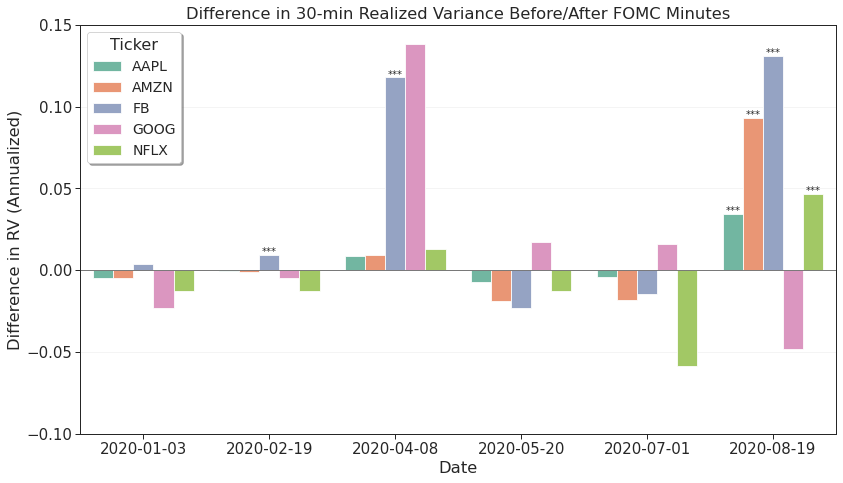

In [1050]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(
    y="rv_difference",
    x="date",
    hue="ticker",
    palette=sns.color_palette("Set2", 5),
    data=data_ttest_all_df,
    ax=ax,
)
plt.axhline(0, -1, 1, color="k", lw=0.5)

# Add significance stars
plt.ylim(-1, 1)
for rectangle in ax.patches:
    x, y = rectangle.get_xy()
    height = rectangle.get_height()
    width = rectangle.get_width()
    x_loc = x + width / 2
    y_loc = height if height > 0 else height - 0.045
    pvalue = data_ttest_all_df["p"].loc[
        (np.abs(data_ttest_all_df["rv_difference"] - height)).idxmin()
    ]
    plt.text(x_loc, y_loc, sig_stars(pvalue), fontsize = 10, ha="center")

# Fix legend
plt.legend(
    loc="upper left",
    title="Ticker",
    title_fontsize=16,
    fontsize=14,
    shadow=True,
)

plt.ylim(-0.1, 0.15)
plt.title('Difference in 30-min Realized Variance Before/After FOMC Minutes')
plt.ylabel('Difference in RV (Annualized)')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig('../exhibits/rv_diffs_minutes.pdf')

#### 60 min

In [1051]:
data_ttest_df_list = []

for start_dt in statement_release_datetimes:

    start_dt = pd.to_datetime(start_dt)
    end_dt = start_dt + pd.Timedelta("60min")

    # Do ttest
    data_ttest_df = (
        data_60min_df.groupby("ticker")
        .apply(lambda x: test_RV_change(x, start_dt, end_dt, x["ticker"][0]))
        .apply(pd.Series)
        .reset_index()
    )
    
    # Add date col
    data_ttest_df["date"] = pd.to_datetime(start_dt).date()
    
    # Fix RV units to annualize
    data_ttest_df[["rv_before", "rv_after", "rv_difference"]] = data_ttest_df[
        ["rv_before", "rv_after", "rv_difference"]
    ] * 250 * (390/60)

    data_ttest_df_list.append(data_ttest_df)
    
data_ttest_all_df = pd.concat(data_ttest_df_list).reset_index(drop = True)
data_ttest_all_df.sample(5)

,ticker,rv_before,rv_after,rv_difference,se_difference,t_stat,p,date
6,AMZN,0.008256,0.003881,-0.004375,0.000003,-0.845301,0.397943,2020-02-19
28,GOOG,0.149385,0.165703,0.016318,0.000039,0.254427,0.799166,2020-08-19
10,AAPL,0.021888,0.042475,0.020586,0.000008,1.655805,0.097761,2020-04-08
3,GOOG,0.016418,0.006415,-0.010004,0.000009,-0.707609,0.479188,2020-01-03
1,AMZN,0.030865,0.003449,-0.027416,0.000011,-1.515546,0.129634,2020-01-03


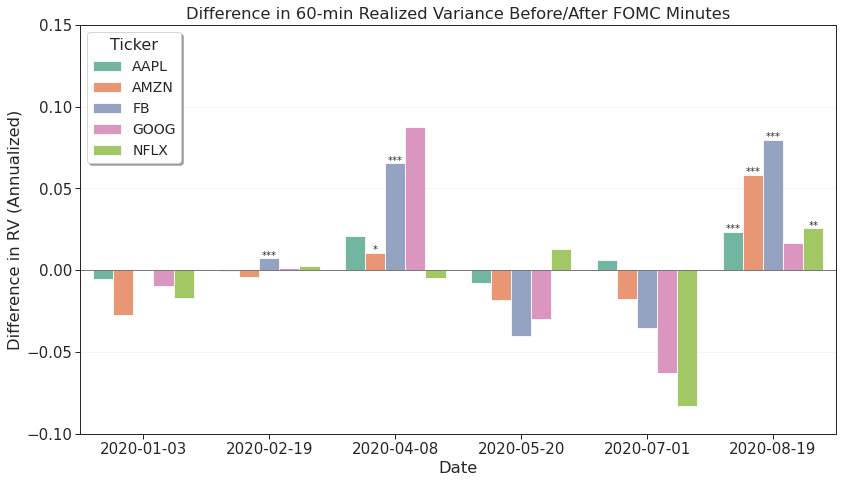

In [1052]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(
    y="rv_difference",
    x="date",
    hue="ticker",
    palette=sns.color_palette("Set2", 5),
    data=data_ttest_all_df,
    ax=ax,
)
plt.axhline(0, -1, 1, color="k", lw=0.5)

# Add significance stars
plt.ylim(-1, 1)
for rectangle in ax.patches:
    x, y = rectangle.get_xy()
    height = rectangle.get_height()
    width = rectangle.get_width()
    x_loc = x + width / 2
    y_loc = height if height > 0 else height - 0.045
    pvalue = data_ttest_all_df["p"].loc[
        (np.abs(data_ttest_all_df["rv_difference"] - height)).idxmin()
    ]
    plt.text(x_loc, y_loc, sig_stars(pvalue), fontsize = 10, ha="center")

# Fix legend
plt.legend(
    loc="upper left",
    title="Ticker",
    title_fontsize=16,
    fontsize=14,
    shadow=True,
)

plt.ylim(-0.1, 0.15)
plt.title('Difference in 60-min Realized Variance Before/After FOMC Minutes')
plt.ylabel('Difference in RV (Annualized)')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig('../exhibits/rv_diffs_minutes_60min.pdf')